<a href="https://colab.research.google.com/github/shivanic02/SpaceHACK-2025/blob/main/SpaceHACK_Team_7_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Google Earth Data

In [ ]:
# Install required libraries
!pip install earthengine-api
!pip install folium

import ee
from google.oauth2 import service_account
import folium

# Path to your downloaded JSON key file
SERVICE_ACCOUNT_KEY_FILE = '/content/spacehack2025-454422-764219dc03b0.json'

# Service account email
SERVICE_ACCOUNT_EMAIL = 'spacehack@spacehack2025-454422.iam.gserviceaccount.com'

# Authenticate using the service account
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_KEY_FILE,
    scopes=['https://www.googleapis.com/auth/earthengine']
)

# Initialize Earth Engine with credentials
ee.Initialize(credentials)

# Test-1

In [ ]:
# Define Phoenix, Arizona, as a point and create a buffer around it
phoenix_point = ee.Geometry.Point([-112.0740, 33.4484])
phoenix_buffer = phoenix_point.buffer(10000)  # 10 km buffer

# Land Use/ Land Cover Data
lulc = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD")
lulc_2019 = lulc.filter(ee.Filter.eq('system:index', '2019')).first()
phoenix_lulc = lulc_2019.clip(phoenix_buffer)

# Vegetation Indices (NDVI)
sentinel2 = ee.ImageCollection("COPERNICUS/S2")
filtered_s2 = sentinel2.filterBounds(phoenix_buffer).filterDate('2022-01-01', '2022-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
ndvi = filtered_s2.mean().normalizedDifference(['B8', 'B4']).clip(phoenix_buffer)

# Soil Moisture Data
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")
smap_filtered = smap.filterBounds(phoenix_buffer).filterDate('2022-01-01', '2022-12-31')
soil_moisture = smap_filtered.mean().clip(phoenix_buffer)

# Ensure barren_land is a single-band image
barren_land = phoenix_lulc.select('landcover').eq(31)  # Class 31 represents barren land

# Ensure low_vegetation is a single-band image
low_vegetation = ndvi.select('nd').lt(0.2)  # Use the correct band name 'nd'

# Ensure suitable_soil is a single-band image
suitable_soil = soil_moisture.select('sm_surface').gt(0.2)  # Select the 'sm_surface' band

# Combine the conditions using logical AND
suitable_sites = barren_land.And(low_vegetation).And(suitable_soil)

# Define a method for displaying Earth Engine images on a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the method to folium
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map centered on Phoenix
my_map = folium.Map(location=[33.4484, -112.0740], zoom_start=12)

# Add the suitable sites layer to the map with a gradient color palette
vis_params = {'min': 0, 'max': 1, 'palette': ['blue', 'yellow', 'green']}  # Gradient from blue (unsuitable) to green (suitable)
my_map.add_ee_layer(suitable_sites, vis_params, 'Suitable Sites')

# Add the 10 km buffer perimeter to the map
folium.GeoJson(
    phoenix_buffer.getInfo(),
    name='10 km Buffer',
    style_function=lambda x: {'color': 'red', 'weight': 2, 'fillOpacity': 0}
).add_to(my_map)

# Add layer control to toggle layers
folium.LayerControl().add_to(my_map)

# Display the map
my_map.save('urban_agriculture_map.html')

In [ ]:

# Define Phoenix, Arizona, as a point and create a buffer around it
phoenix_point = ee.Geometry.Point([-112.0740, 33.4484])
phoenix_buffer = phoenix_point.buffer(10000)  # 10 km buffer

# Land Use/Land Cover Data
lulc = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD").sort('system:time_start', False).first()
lulc = lulc.select('landcover').clip(phoenix_buffer)

# Vegetation Indices (NDVI)
sentinel2 = ee.ImageCollection("COPERNICUS/S2")
filtered_s2 = sentinel2.filterBounds(phoenix_buffer).filterDate('2019-01-01', '2019-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
ndvi = filtered_s2.mean().normalizedDifference(['B8', 'B4']).rename('ndvi').clip(phoenix_buffer)

# Soil Moisture Data
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")
smap_filtered = smap.filterBounds(phoenix_buffer).filterDate('2019-01-01', '2019-12-31')
soil_moisture = smap_filtered.mean().select('sm_surface').clip(phoenix_buffer)

# Ensure barren_land is correctly classified
barren_land = lulc.eq(31)  # Class 31 represents barren land

# Ensure low_vegetation is a single-band image
low_vegetation = ndvi.lt(0.2)

# Ensure suitable_soil is a single-band image
suitable_soil = soil_moisture.gt(0.2)

# Combine the conditions using multiplication
suitable_sites = barren_land.multiply(low_vegetation).multiply(suitable_soil)

# Define a method for displaying Earth Engine images on a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the method to folium
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map centered on Phoenix
my_map = folium.Map(location=[33.4484, -112.0740], zoom_start=12)

# Add the suitable sites layer to the map with a gradient color palette
vis_params = {'min': 0, 'max': 1, 'palette': ['blue', 'yellow', 'green']}  # Gradient from blue (unsuitable) to green (suitable)
my_map.add_ee_layer(suitable_sites, vis_params, 'Suitable Sites')

# Add the 10 km buffer perimeter to the map
folium.GeoJson(
    phoenix_buffer.getInfo(),
    name='10 km Buffer',
    style_function=lambda x: {'color': 'red', 'weight': 2, 'fillOpacity': 0}
).add_to(my_map)

# Add layer control to toggle layers
folium.LayerControl().add_to(my_map)

# Save the map to an HTML file
my_map.save('urban_agriculture_map.html')


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


# Test-2

In [ ]:
phoenix = ee.Geometry.Point([-112.0740, 33.4484]).buffer(15000)

# Land cover
lulc = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD") \
         .first().select('landcover').clip(phoenix)
suitable_land = lulc.remap([31, 52, 71, 81], [1, 1, 1, 1], 0)

# NDVI (Memory-optimized)
sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
              .filterBounds(phoenix) \
              .filterDate('2019-01-01', '2019-12-31') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

s2_proj = sentinel2.first().select('B8').projection()
ndvi = sentinel2.qualityMosaic('NDVI') \
       .normalizedDifference(['B8', 'B4']) \
       .rename('ndvi') \
       .setDefaultProjection(s2_proj) \
       .reduceResolution(reducer=ee.Reducer.mean(), bestEffort=True)

# Soil moisture
smap_proj = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007") \
             .first().select('sm_surface').projection()
soil_moisture = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007") \
                .filterDate('2019-01-01', '2019-12-31') \
                .median() \
                .select('sm_surface') \
                .setDefaultProjection(smap_proj) \
                .reduceResolution(reducer=ee.Reducer.mean(), bestEffort=True)

# Threshold calculation
soil_threshold = soil_moisture.reduceRegion(
    reducer=ee.Reducer.percentile([50]),
    geometry=phoenix,
    scale=500,
    bestEffort=True,
    maxPixels=1e9
).get('sm_surface')
suitable_soil = soil_moisture.gt(soil_threshold)

# Final score
suitability_score = suitable_land.multiply(2) \
                       .add(ndvi.lt(0.2)) \
                       .add(suitable_soil.multiply(2)) \
                       .divide(5)

# Export instead of direct visualization
export_task = ee.batch.Export.image.toDrive(
    image=suitability_score,
    description='phoenix_ag_suitability',
    scale=30,
    region=phoenix,
    fileFormat='GeoTIFF',
    maxPixels=1e10
)
export_task.start()
print(f'Export started with ID: {export_task.id}')


Export started with ID: WKDHBAC6PHDMDE4VD42PZHVT


In [ ]:
# Define Phoenix, Arizona, as a point and create a smaller buffer (15 km)
phoenix_point = ee.Geometry.Point([-112.0740, 33.4484])
phoenix_buffer = phoenix_point.buffer(15000)  # 15 km buffer

# Land Use/Land Cover Data
lulc = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD") \
         .first().select('landcover').clip(phoenix_buffer)

# Broaden the classification for suitable land
suitable_land = lulc.remap([31, 52, 71, 81], [1, 1, 1, 1], 0)

# Vegetation Indices (NDVI)
sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
              .filterBounds(phoenix_buffer) \
              .filterDate('2019-01-01', '2019-12-31') \
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Get Sentinel-2 native projection
s2_proj = sentinel2.first().select('B8').projection()

ndvi = sentinel2.median() \
       .normalizedDifference(['B8', 'B4']) \
       .rename('ndvi') \
       .clip(phoenix_buffer) \
       .setDefaultProjection(s2_proj)

# Soil Moisture Data
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007") \
         .filterBounds(phoenix_buffer) \
         .filterDate('2019-01-01', '2019-12-31')

soil_moisture = smap.median() \
                .select('sm_surface') \
                .clip(phoenix_buffer)

# Calculate soil moisture threshold
soil_threshold = soil_moisture.reduceRegion(
    reducer=ee.Reducer.percentile([50]),
    geometry=phoenix_buffer,
    scale=500,
    bestEffort=True,
    maxPixels=1e9
).get('sm_surface')

suitable_soil = soil_moisture.gt(soil_threshold)

# Compute weighted suitability score
suitability_score = suitable_land.multiply(2) \
                      .add(ndvi.lt(0.2)) \
                      .add(suitable_soil.multiply(2)) \
                      .divide(5)

# Visualization parameters for suitability score
suitability_vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['red', 'orange', 'yellow', 'lime']
}

# Create a Folium map centered on Phoenix
my_map = folium.Map(location=[33.4484, -112.0740], zoom_start=12)

# Add the suitability score as a layer to the map
tile_url = suitability_score.visualize(**suitability_vis_params).getMapId()['tile_fetcher'].url_format

folium.raster_layers.TileLayer(
    tiles=tile_url,
    attr='Google Earth Engine',
    name='Agricultural Suitability',
    overlay=True,
    control=True
).add_to(my_map)

# Add the buffer boundary to the map
folium.GeoJson(
    phoenix_buffer.getInfo(),
    name='15 km Buffer',
    style_function=lambda x: {'color': 'blue', 'weight': 2, 'fillOpacity': 0}
).add_to(my_map)

# Add layer control to toggle layers on/off
folium.LayerControl().add_to(my_map)

# Save the map as an HTML file
my_map.save('phoenix_urban_ag_suitability.html')
print("Map saved as 'phoenix_urban_ag_suitability.html'")

EEException: User memory limit exceeded.

EEException: User memory limit exceeded.

# Test-3

In [ ]:

# Define Phoenix, Arizona, as a point and create a buffer around it
phoenix_point = ee.Geometry.Point([-112.0740, 33.4484])
phoenix_buffer = phoenix_point.buffer(15000)  # Increased to 15 km buffer

# Land Use/Land Cover Data
lulc = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD")
lulc_2019 = lulc.filter(ee.Filter.eq('system:index', '2019')).first()
phoenix_lulc = lulc_2019.clip(phoenix_buffer)

# Vegetation Indices (NDVI)
sentinel2 = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
filtered_s2 = sentinel2.filterBounds(phoenix_buffer).filterDate('2024-01-01', '2024-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
ndvi = filtered_s2.median().normalizedDifference(['B8', 'B4']).rename('ndvi').clip(phoenix_buffer)

# Soil Moisture Data
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")
smap_filtered = smap.filterBounds(phoenix_buffer).filterDate('2024-01-01', '2024-12-31')
soil_moisture = smap_filtered.mean().select('sm_surface').clip(phoenix_buffer)

# Define underutilized areas
underutilized_lulc = phoenix_lulc.select('landcover').remap(
    [21, 22, 23, 24, 31, 52, 71, 81, 82],  # Developed areas, barren land, shrub/scrub, grassland, pasture/hay, cultivated crops
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    0
)

low_vegetation = ndvi.lt(0.3)  # Adjusted threshold for low vegetation
moderate_soil_moisture = soil_moisture.gt(0.1).And(soil_moisture.lt(0.4))  # Adjusted soil moisture range

# Combine conditions for potential urban agriculture sites
potential_sites = underutilized_lulc.And(low_vegetation).And(moderate_soil_moisture)

# Create a folium map centered on Phoenix
my_map = folium.Map(location=[33.4484, -112.0740], zoom_start=11)

# Add the potential sites layer to the map with an adjusted color palette
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['000000', '808080', 'FFFF00', '00FF00'],  # Black (unsuitable) to green (highly suitable)
    'opacity': 0.7
}

# Define a method for displaying Earth Engine images on a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the method to folium
folium.Map.add_ee_layer = add_ee_layer

my_map.add_ee_layer(potential_sites, vis_params, 'Potential Urban Agriculture Sites')

# Add the 15 km buffer perimeter to the map
folium.GeoJson(
    phoenix_buffer.getInfo(),
    name='15 km Buffer',
    style_function=lambda x: {'color': 'blue', 'weight': 2, 'fillOpacity': 0}
).add_to(my_map)

# Add layer control to toggle layers
folium.LayerControl().add_to(my_map)

# Save the map
my_map.save('phoenix_urban_agriculture_potential.html')
print("Map saved as 'phoenix_urban_agriculture_potential.html'")


Map saved as 'phoenix_urban_agriculture_potential.html'


# Test-4

In [ ]:

# Define Phoenix, Arizona, as a point and create a buffer around it
phoenix_point = ee.Geometry.Point([-112.0740, 33.4484])
phoenix_buffer = phoenix_point.buffer(15000)  # Increased to 15 km buffer

# Land Use/Land Cover Data
lulc = ee.ImageCollection("USGS/NLCD_RELEASES/2019_REL/NLCD").sort('system:time_start', False).first()
lulc = lulc.select('landcover').clip(phoenix_buffer)

# Classify land cover types
barren_land = lulc.eq(31)
urban_areas = lulc.gte(21).And(lulc.lte(24))
vegetation = lulc.eq(52).Or(lulc.eq(71)).Or(lulc.eq(81)).Or(lulc.eq(82))

# Combine classifications
land_classification = barren_land.add(urban_areas.multiply(2)).add(vegetation.multiply(3))

# Create a folium map centered on Phoenix
my_map = folium.Map(location=[33.4484, -112.0740], zoom_start=11)

# Define a method for displaying Earth Engine images on a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the method to folium
folium.Map.add_ee_layer = add_ee_layer

# Add the land classification layer to the map
vis_params = {
    'min': 1,
    'max': 3,
    'palette': ['yellow', 'cyan', 'green']
}
my_map.add_ee_layer(land_classification, vis_params, 'Land Classification')

# Add the 15 km buffer perimeter to the map
folium.GeoJson(
    phoenix_buffer.getInfo(),
    name='15 km Buffer',
    style_function=lambda x: {'color': 'red', 'weight': 2, 'fillOpacity': 0}
).add_to(my_map)

# Add layer control to toggle layers
folium.LayerControl().add_to(my_map)

# Save the map to an HTML file
my_map.save('phoenix_land_classification_map.html')
print("Map saved as 'phoenix_land_classification_map.html'")


Map saved as 'phoenix_land_classification_map.html'


# Approach 1

In [ ]:
# Install required libraries
!pip install earthengine-api
!pip install folium

import ee
from google.oauth2 import service_account
import folium

# Path to your downloaded JSON key file
SERVICE_ACCOUNT_KEY_FILE = '/content/spacehack2025-454422-764219dc03b0.json'

# Service account email
SERVICE_ACCOUNT_EMAIL = 'spacehack@spacehack2025-454422.iam.gserviceaccount.com'

# Authenticate using the service account
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_KEY_FILE,
    scopes=['https://www.googleapis.com/auth/earthengine']
)

# Initialize Earth Engine with credentials
ee.Initialize(credentials)

In [ ]:
# Run these commands first in separate cells
!pip install earthengine-api --quiet
!apt-get install glpk-utils --quiet  # Required for Pyomo solver
!pip install geopandas folium pyomo xgboost dash dash-leaflet --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-utils amd64 5.0-1

## Land Cover and NDVI layers in Arizona

In [ ]:
# Define Arizona state boundary
arizona = ee.FeatureCollection("TIGER/2018/States") \
    .filter(ee.Filter.eq('NAME', 'Arizona')) \
    .geometry()

# Load Land Cover Data (ESA WorldCover)
landcover = ee.Image('ESA/WorldCover/v100/2020').clip(arizona)

# Load NDVI Data (Sentinel-2)
ndvi = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(arizona) \
    .filterDate('2022-01-01', '2022-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median() \
    .normalizedDifference(['B8', 'B4']) \
    .rename('NDVI') \
    .clip(arizona)

# Define a method for displaying Earth Engine images on a folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the method to folium
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map centered on Arizona
my_map = folium.Map(location=[34.0489, -111.0937], zoom_start=7)

# Add Land Cover Choropleth Map with lower opacity
landcover_viz = {
    'min': 0,
    'max': 11,
    'palette': [
        '#006400',  # Tree cover
        '#FFBB22',  # Shrubland
        '#FFFF4C',  # Grassland
        '#F096FF',  # Cropland
        '#FA0000',  # Built-up
        '#B4B4B4',  # Bare/sparse vegetation
        '#F0F0F0',  # Snow and ice
        '#0064C8',  # Permanent water bodies
        '#0096A0',  # Herbaceous wetland
        '#00CF75',  # Mangroves
        '#FAE6A0'   # Moss and lichen
    ],
    'opacity': 0.5  # Lower opacity (50%)
}
my_map.add_ee_layer(landcover, landcover_viz, 'Land Cover')

# Add NDVI Intensity Map with lower opacity
ndvi_viz = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'yellow', 'green'],  # Red: Low vegetation, Green: High vegetation
    'opacity': 0.5  # Lower opacity (50%)
}
my_map.add_ee_layer(ndvi, ndvi_viz, 'NDVI')

# Add Legends
# Land Cover Legend
landcover_legend = {
    'Tree Cover': '#006400',
    'Shrubland': '#FFBB22',
    'Grassland': '#FFFF4C',
    'Cropland': '#F096FF',
    'Built-up': '#FA0000',
    'Bare/Sparse Vegetation': '#B4B4B4',
    'Snow and Ice': '#F0F0F0',
    'Water Bodies': '#0064C8',
    'Herbaceous Wetland': '#0096A0',
    'Mangroves': '#00CF75',
    'Moss and Lichen': '#FAE6A0'
}

# Create a FeatureGroup for the land cover legend
landcover_legend_group = folium.FeatureGroup(name='Land Cover Legend')
for label, color in landcover_legend.items():
    landcover_legend_group.add_child(
        folium.Marker(
            location=[0, 0],  # Dummy location (legends are added as markers)
            icon=folium.Icon(color='white', icon_color=color, icon='square', prefix='fa'),
            popup=label
        )
    )
my_map.add_child(landcover_legend_group)

# NDVI Legend
ndvi_legend = {
    'Low Vegetation': 'red',
    'Medium Vegetation': 'yellow',
    'High Vegetation': 'green'
}

# Create a FeatureGroup for the NDVI legend
ndvi_legend_group = folium.FeatureGroup(name='NDVI Legend')
for label, color in ndvi_legend.items():
    ndvi_legend_group.add_child(
        folium.Marker(
            location=[0, 0],  # Dummy location (legends are added as markers)
            icon=folium.Icon(color='white', icon_color=color, icon='square', prefix='fa'),
            popup=label
        )
    )
my_map.add_child(ndvi_legend_group)

# Add layer control to toggle layers
folium.LayerControl().add_to(my_map)

# Save the map as an HTML file
my_map.save('arizona_landcover_ndvi_map.html')
print("Map saved as 'arizona_landcover_ndvi_map.html'")

Map saved as 'arizona_landcover_ndvi_map.html'


## Income and Population Density for Food Deserts

In [ ]:
# Load MODIS Land Cover data
land_cover = ee.ImageCollection("MODIS/006/MCD12Q1").filterDate('2020-01-01', '2020-12-31').first()

# # Select urban areas (class 13 in MODIS Land Cover)
# urban_areas = land_cover.select('LC_Type1').eq(13)

# # Check if the image is loaded correctly
# print(land_cover.getInfo())

In [ ]:
# Load NLCD land cover data
nlcd = ee.ImageCollection("USGS/NLCD").filterDate('2019-01-01', '2019-12-31').first()

# Check if the image is loaded correctly
print(nlcd.getInfo())

None


In [ ]:
# Load WorldPop population data
population = ee.ImageCollection("WorldPop/GP/100m/pop").filterDate('2020-01-01', '2020-12-31').first()

# Load GHSL dataset (as a proxy for income)
ghsl = ee.ImageCollection("JRC/GHSL/P2016/SMOD_POP_GLOBE_V1").filterDate('2015-01-01', '2015-12-31').first()

In [ ]:
# Example: Manually define grocery store locations
grocery_stores = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([-112.074, 33.448])),  # Phoenix, AZ
    ee.Feature(ee.Geometry.Point([-111.978, 33.415]))  # Tempe, AZ
])

In [ ]:
# Calculate distance to grocery stores
distance_to_stores = urban_areas.distance(grocery_stores)

In [ ]:
# Define thresholds
low_income_threshold = 50000  # Example: Annual income < $50,000
low_access_threshold = 1000    # Example: Distance > 1 km

# Identify low-income areas
low_income_areas = income.lt(low_income_threshold)

# Identify low-access areas
low_access_areas = distance_to_stores.gt(low_access_threshold)

# Combine criteria to identify food deserts
food_deserts = urban_areas.And(low_income_areas).And(low_access_areas)

In [ ]:
import geemap

# Create a map
m = geemap.Map()

# Add layers to the map
m.addLayer(urban_areas, {'palette': 'gray'}, 'Urban Areas')
m.addLayer(low_income_areas, {'palette': 'orange'}, 'Low Income Areas')
m.addLayer(low_access_areas, {'palette': 'blue'}, 'Low Access Areas')
m.addLayer(food_deserts, {'palette': 'red'}, 'Food Deserts')

# Display the map
m

EEException: Image.lt: Parameter 'image1' is required and may not be null.

In [ ]:


# Load MODIS Land Cover data
land_cover = ee.ImageCollection("MODIS/006/MCD12Q1").filterDate('2020-01-01', '2020-12-31').first()
urban_areas = land_cover.select('LC_Type1').eq(13)

# Load WorldPop population data
population = ee.ImageCollection("WorldPop/GP/100m/pop").filterDate('2020-01-01', '2020-12-31').first()

# Load GHSL dataset (as a proxy for income)
ghsl = ee.ImageCollection("JRC/GHSL/P2016/SMOD_POP_GLOBE_V1").filterDate('2015-01-01', '2015-12-31').first()

# Define grocery store locations
grocery_stores = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([-112.074, 33.448])),  # Phoenix, AZ
    ee.Feature(ee.Geometry.Point([-111.978, 33.415]))  # Tempe, AZ
])

# Convert grocery store locations to an image
grocery_stores_image = ee.Image().paint(grocery_stores, 1)

# Define a distance kernel (e.g., 10 km radius)
distance_kernel = ee.Kernel.euclidean(radius=10000, units='meters')

# Calculate distance to grocery stores
distance_to_stores = grocery_stores_image.distance(distance_kernel)

# Define thresholds
low_income_threshold = 50000  # Example: Annual income < $50,000
low_access_threshold = 1000    # Example: Distance > 1 km

# Identify low-income areas (using GHSL as a proxy)
low_income_areas = ghsl.select('smod_code').lt(low_income_threshold)

# Identify low-access areas
low_access_areas = distance_to_stores.gt(low_access_threshold)

# Combine criteria to identify food deserts
food_deserts = urban_areas.And(low_income_areas).And(low_access_areas)

# Create a map
m = geemap.Map()

# Add layers to the map
m.addLayer(urban_areas, {'palette': 'gray'}, 'Urban Areas')
m.addLayer(low_income_areas, {'palette': 'orange'}, 'Low Income Areas')
m.addLayer(low_access_areas, {'palette': 'blue'}, 'Low Access Areas')
m.addLayer(food_deserts, {'palette': 'red'}, 'Food Deserts')

# Display the map
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Approach-2

In [ ]:
# Install necessary libraries
!pip install geemap geopandas rasterio folium plotly

# Import libraries
import ee
import geemap
import geopandas as gpd
import rasterio
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

print("Libraries imported and GEE initialized successfully!")

Libraries imported and GEE initialized successfully!


In [ ]:
# Create an interactive map using geemap
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Load USDA NASS Cropland Data Layer for 2022
cdl = ee.ImageCollection('USDA/NASS/CDL')
cdl_2022 = cdl.filterDate('2022-01-01', '2022-12-31').first()

# Add the layer to the map
Map.addLayer(cdl_2022, {}, 'Cropland Data Layer 2022')
Map

Map(bottom=812.0, center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
# Define a point of interest (replace with coordinates of a dark blue or dark pink region)
point = ee.Geometry.Point([-112.0740, 33.4484])  # Example: Phoenix, Arizona

# Extract the pixel value at the point
pixel_value = cdl_2022.sample(point, scale=30).first().get('cropland').getInfo()

# Print the pixel value
print("Pixel Value (Land Cover Code):", pixel_value)

Pixel Value (Land Cover Code): 124


In [ ]:
# Load MODIS NDVI dataset
modis_ndvi = ee.ImageCollection('MODIS/006/MOD13Q1')

# Filter for the most recent year
recent_ndvi = modis_ndvi.filterDate('2022-01-01', '2022-12-31').first()

# Select the NDVI band
ndvi = recent_ndvi.select('NDVI')

# Add the NDVI layer to the map
Map.addLayer(ndvi, {'min': 0, 'max': 9000, 'palette': ['red', 'yellow', 'green']}, 'NDVI 2022')
Map

Map(bottom=812.0, center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
# Load Landsat 8 imagery
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Filter for the Phoenix metro area and a specific time range
phoenix_roi = ee.Geometry.Rectangle([-112.5, 33.0, -111.5, 34.0])  # Approximate Phoenix metro area
landsat_phoenix = landsat.filterBounds(phoenix_roi).filterDate('2015-01-01', '2023-01-01')

# Select the first and last images for comparison
first_image = landsat_phoenix.first()
last_image = landsat_phoenix.sort('system:time_start', False).first()

# Add the images to the map
Map.addLayer(first_image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 3000}, 'Landsat 2015')
Map.addLayer(last_image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 3000}, 'Landsat 2023')
Map

Map(bottom=812.0, center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [ ]:
# Load USDA Food Access Atlas data (replace with your file path)
food_access = gpd.read_file('/content/Food Access Research Atlas.csv')

# Display the first few rows
print(food_access.head())

  CensusTract    State          County Urban Pop2010 OHU2010  \
0  1001020100  Alabama  Autauga County     1    1912     693   
1  1001020200  Alabama  Autauga County     1    2170     743   
2  1001020300  Alabama  Autauga County     1    3373    1256   
3  1001020400  Alabama  Autauga County     1    4386    1722   
4  1001020500  Alabama  Autauga County     1   10766    4082   

  GroupQuartersFlag NUMGQTRS PCTGQTRS LILATracts_1And10  ... TractSeniors  \
0                 0        0        0                 0  ...          221   
1                 0      181     8.34                 1  ...          214   
2                 0        0        0                 0  ...          439   
3                 0        0        0                 0  ...          904   
4                 0      181     1.68                 0  ...         1126   

  TractWhite TractBlack TractAsian TractNHOPI TractAIAN TractOMultir  \
0       1622        217         14          0        14           45   
1       

In [ ]:
# Import necessary libraries
import ee
import geemap
import folium
from branca.element import MacroElement
from jinja2 import Template

# # Initialize Google Earth Engine
# ee.Initialize()

# Create an interactive map
Map = geemap.Map()

# Load USDA NASS Cropland Data Layer for 2022
cdl = ee.ImageCollection('USDA/NASS/CDL')
cdl_2022 = cdl.filterDate('2022-01-01', '2022-12-31').first()

# Select the 'cropland' band
cdl_2022 = cdl_2022.select('cropland')

# Define the CDL legend (mapping of codes to land cover types)
cdl_legend = {
    0: "Background",
    1: "Corn",
    2: "Cotton",
    3: "Rice",
    4: "Sorghum",
    5: "Soybeans",
    6: "Sunflower",
    10: "Peanuts",
    11: "Tobacco",
    12: "Sweet Corn",
    13: "Pop or Orn Corn",
    14: "Mint",
    21: "Barley",
    22: "Durum Wheat",
    23: "Spring Wheat",
    24: "Winter Wheat",
    25: "Other Small Grains",
    26: "Dbl Crop WinWht/Soybeans",
    27: "Rye",
    28: "Oats",
    29: "Millet",
    30: "Speltz",
    31: "Canola",
    32: "Flaxseed",
    33: "Safflower",
    34: "Rape Seed",
    35: "Mustard",
    36: "Alfalfa",
    37: "Other Hay/Non Alfalfa",
    38: "Camelina",
    39: "Buckwheat",
    41: "Sugarbeets",
    42: "Dry Beans",
    43: "Potatoes",
    44: "Other Crops",
    45: "Sugarcane",
    46: "Sweet Potatoes",
    47: "Misc Vegs & Fruits",
    48: "Watermelons",
    49: "Onions",
    50: "Cucumbers",
    51: "Chick Peas",
    52: "Lentils",
    53: "Peas",
    54: "Tomatoes",
    55: "Caneberries",
    56: "Hops",
    57: "Herbs",
    58: "Clover/Wildflowers",
    59: "Sod/Grass Seed",
    60: "Switchgrass",
    61: "Fallow/Idle Cropland",
    63: "Forest",
    64: "Shrubland",
    65: "Barren",
    66: "Cherries",
    67: "Peaches",
    68: "Apples",
    69: "Grapes",
    70: "Christmas Trees",
    71: "Other Tree Crops",
    72: "Citrus",
    74: "Pecans",
    75: "Almonds",
    76: "Walnuts",
    77: "Pears",
    81: "Clouds/No Data",
    82: "Developed",
    83: "Water",
    87: "Wetlands",
    88: "Nonag/Undefined",
    92: "Aquaculture",
    111: "Open Water",
    112: "Perennial Ice/Snow",
    121: "Developed/Open Space",
    122: "Developed/Low Intensity",
    123: "Developed/Medium Intensity",
    124: "Developed/High Intensity",
    131: "Barren",
    141: "Deciduous Forest",
    142: "Evergreen Forest",
    143: "Mixed Forest",
    152: "Shrubland",
    176: "Grassland/Pasture",
    190: "Woody Wetlands",
    195: "Herbaceous Wetlands",
    204: "Pistachios",
    205: "Triticale",
    206: "Carrots",
    207: "Asparagus",
    208: "Garlic",
    209: "Cantaloupes",
    210: "Prunes",
    211: "Olives",
    212: "Oranges",
    213: "Honeydew Melons",
    214: "Broccoli",
    215: "Avocados",
    216: "Peppers",
    217: "Pomegranates",
    218: "Nectarines",
    219: "Greens",
    220: "Plums",
    221: "Strawberries",
    222: "Squash",
    223: "Apricots",
    224: "Vetch",
    225: "Dbl Crop WinWht/Corn",
    226: "Dbl Crop Oats/Corn",
    227: "Lettuce",
    228: "Pumpkins",
    229: "Dbl Crop Lettuce/Durum Wht",
    230: "Dbl Crop Lettuce/Cantaloupe",
    231: "Dbl Crop Lettuce/Cotton",
    232: "Dbl Crop Lettuce/Barley",
    233: "Dbl Crop Durum Wht/Sorghum",
    234: "Dbl Crop Barley/Sorghum",
    235: "Dbl Crop WinWht/Sorghum",
    236: "Dbl Crop Barley/Corn",
    237: "Dbl Crop WinWht/Cotton",
    238: "Dbl Crop Soybeans/Cotton",
    239: "Dbl Crop Soybeans/Oats",
    240: "Dbl Crop Corn/Soybeans",
    241: "Blueberries",
    242: "Cabbage",
    243: "Cauliflower",
    244: "Celery",
    245: "Radishes",
    246: "Turnips",
    247: "Eggplants",
    248: "Gourds",
    249: "Cranberries",
    250: "Dbl Crop Barley/Soybeans"
}

# Define food-related land cover codes
food_related_codes = [
    1,  # Corn
    2,  # Cotton
    3,  # Rice
    4,  # Sorghum
    5,  # Soybeans
    10,  # Peanuts
    12,  # Sweet Corn
    21,  # Barley
    22,  # Durum Wheat
    23,  # Spring Wheat
    24,  # Winter Wheat
    25,  # Other Small Grains
    26,  # Dbl Crop WinWht/Soybeans
    27,  # Rye
    28,  # Oats
    29,  # Millet
    30,  # Speltz
    31,  # Canola
    32,  # Flaxseed
    33,  # Safflower
    34,  # Rape Seed
    35,  # Mustard
    36,  # Alfalfa
    37,  # Other Hay/Non Alfalfa
    41,  # Sugarbeets
    42,  # Dry Beans
    43,  # Potatoes
    44,  # Other Crops
    45,  # Sugarcane
    46,  # Sweet Potatoes
    47,  # Misc Vegs & Fruits
    48,  # Watermelons
    49,  # Onions
    50,  # Cucumbers
    51,  # Chick Peas
    52,  # Lentils
    53,  # Peas
    54,  # Tomatoes
    55,  # Caneberries
    56,  # Hops
    57,  # Herbs
    58,  # Clover/Wildflowers
    59,  # Sod/Grass Seed
    60,  # Switchgrass
    61,  # Fallow/Idle Cropland
    66,  # Cherries
    67,  # Peaches
    68,  # Apples
    69,  # Grapes
    70,  # Christmas Trees
    71,  # Other Tree Crops
    72,  # Citrus
    74,  # Pecans
    75,  # Almonds
    76,  # Walnuts
    77,  # Pears
    204,  # Pistachios
    205,  # Triticale
    206,  # Carrots
    207,  # Asparagus
    208,  # Garlic
    209,  # Cantaloupes
    210,  # Prunes
    211,  # Olives
    212,  # Oranges
    213,  # Honeydew Melons
    214,  # Broccoli
    215,  # Avocados
    216,  # Peppers
    217,  # Pomegranates
    218,  # Nectarines
    219,  # Greens
    220,  # Plums
    221,  # Strawberries
    222,  # Squash
    223,  # Apricots
    224,  # Vetch
    225,  # Dbl Crop WinWht/Corn
    226,  # Dbl Crop Oats/Corn
    227,  # Lettuce
    228,  # Pumpkins
    229,  # Dbl Crop Lettuce/Durum Wht
    230,  # Dbl Crop Lettuce/Cantaloupe
    231,  # Dbl Crop Lettuce/Cotton
    232,  # Dbl Crop Lettuce/Barley
    233,  # Dbl Crop Durum Wht/Sorghum
    234,  # Dbl Crop Barley/Sorghum
    235,  # Dbl Crop WinWht/Sorghum
    236,  # Dbl Crop Barley/Corn
    237,  # Dbl Crop WinWht/Cotton
    238,  # Dbl Crop Soybeans/Cotton
    239,  # Dbl Crop Soybeans/Oats
    240,  # Dbl Crop Corn/Soybeans
    241,  # Blueberries
    242,  # Cabbage
    243,  # Cauliflower
    244,  # Celery
    245,  # Radishes
    246,  # Turnips
    247,  # Eggplants
    248,  # Gourds
    249,  # Cranberries
    250,  # Dbl Crop Barley/Soybeans
    176,  # Grassland/Pasture (for livestock)
]

# Create a mask for food-related land cover classes
food_mask = cdl_2022.eq(food_related_codes[0])
for code in food_related_codes[1:]:
    food_mask = food_mask.Or(cdl_2022.eq(code))

# Apply the mask to the CDL image
food_related = cdl_2022.updateMask(food_mask)

# Add the food-related layer to the map
Map.addLayer(food_related, {'palette': 'green'}, 'Food-Related Land Cover')

# Create a custom legend using folium
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 150px; height: auto;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; padding: 10px;">
         <p><strong>Food-Related Land Cover</strong></p>
         <p><i style="background:green; width: 20px; height: 20px; display: inline-block;"></i> Food-Producing Areas</p>
     </div>
'''

# Add the custom legend to the map
class Legend(MacroElement):
    def __init__(self, html):
        super().__init__()
        self._template = Template(html)

    def render(self, **kwargs):
        self.get_root().html.add_child(folium.Element(self._template.render(**kwargs)))

legend = Legend(legend_html)
# Add the custom legend to the map
Map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
Map

# # Optional: Calculate the total area of food-producing land
# # Define a region of interest (ROI) - Example: Phoenix metro area
# phoenix_roi = ee.Geometry.Rectangle([-112.5, 33.0, -111.5, 34.0])

# # Calculate the area of food-related land cover
# area_image = food_related.multiply(ee.Image.pixelArea())  # Convert pixels to area
# total_area = area_image.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=phoenix_roi,  # Use the defined ROI
#     scale=30,
#     maxPixels=1e13
# ).get('cropland')

# # Print the total area in square meters
# print("Total Food-Producing Area (sq. meters):", total_area.getInfo())

AttributeError: 'Map' object has no attribute 'get_root'

In [ ]:
# Import necessary libraries
import ee
import geemap

# # Initialize Google Earth Engine
# ee.Initialize()

# Create an interactive map
Map = geemap.Map()

# Load USDA NASS Cropland Data Layer for 2022
cdl = ee.ImageCollection('USDA/NASS/CDL')
cdl_2022 = cdl.filterDate('2022-01-01', '2022-12-31').first()

# Select the 'cropland' band
cdl_2022 = cdl_2022.select('cropland')

# Define food-related land cover codes (for agricultural suitability)
food_related_codes = [
    1, 2, 3, 4, 5, 10, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
    34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
    56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 204, 205,
    206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
    221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
    236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
    176  # Grassland/Pasture (for livestock)
]

# Create a mask for food-related cropland areas
food_mask = cdl_2022.remap(food_related_codes, [1] * len(food_related_codes), 0)

# Apply the mask to filter only food-related land cover
food_related = cdl_2022.updateMask(food_mask)

# Add the food-related cropland layer to the map
Map.addLayer(food_related, {'palette': ['green']}, 'Food-Related Cropland')

# Define a region of interest (Phoenix metro area)
phoenix_roi = ee.Geometry.Rectangle([-112.5, 33.0, -111.5, 34.0])

# Calculate the total area of food-related land in square meters
area_image = food_related.multiply(ee.Image.pixelArea())  # Convert pixels to area
total_area = area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=phoenix_roi,
    scale=30,
    maxPixels=1e13
).get('cropland')

# Get the result and convert to square kilometers
total_area_km2 = ee.Number(total_area).divide(1e6)

# Print the total food-producing area
print("Total Food-Producing Area in Phoenix Metro (sq. km):", total_area_km2.getInfo())

# Display the map
Map


Total Food-Producing Area in Phoenix Metro (sq. km): 96276.03298588241


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
import ee
import geemap

# # Initialize Google Earth Engine
# ee.Initialize()

# Create an interactive map
Map = geemap.Map()

# Load USDA Cropland Data for 2022
cdl = ee.ImageCollection('USDA/NASS/CDL')
cdl_2022 = cdl.filterDate('2022-01-01', '2022-12-31').first().select('cropland')

# Define food-related land cover codes
food_related_codes = [
    1, 2, 3, 4, 5, 10, 12, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
    34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
    56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 204,
    205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
    220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
    235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
    250, 176
]

# Create a mask for food-related land cover
food_mask = cdl_2022.eq(food_related_codes[0])
for code in food_related_codes[1:]:
    food_mask = food_mask.Or(cdl_2022.eq(code))

# Apply mask to CDL image
food_related = cdl_2022.updateMask(food_mask)

# Add the layer to the interactive map
Map.addLayer(food_related, {'palette': 'green'}, 'Food-Related Land Cover')

# Add a drawing tool to select a region
Map.add_draw_control()

# Display the interactive map
Map



Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# Function to export selected region as a local image
def export_selected_area():
    roi = Map.user_roi  # Get user-selected region
    if roi:
        print("Exporting the selected area...")

        # Set visualization parameters
        viz_params = {'palette': ['green']}
        export_image = food_related.visualize(**viz_params)

        # Download image locally
        geemap.ee_export_image(export_image, filename="Food_Security_Map.jpeg", scale=30, region=roi, file_per_band=False)
        print("Image saved as Food_Security_Map.jpeg")
    else:
        print("No region selected. Draw an area on the map first!")

# Call this function after selecting an area
export_selected_area()


Exporting the selected area...
The filename must end with .tif
Image saved as Food_Security_Map.jpeg


In [ ]:
import os
print(os.listdir("/content/"))  # Lists files in the working directory


['.config', 'FoodAccess.xlsx', 'arizona_landcover_ndvi_map.html', 'spacehack2025-454422-764219dc03b0.json', 'Food Access Research Atlas.csv', '.ipynb_checkpoints', 'sample_data']


In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
from google.colab import files

# # Initialize Google Earth Engine
# ee.Initialize()

# Create an interactive map
Map = geemap.Map()

# Load USDA NASS Cropland Data Layer for 2022
cdl = ee.ImageCollection('USDA/NASS/CDL')
cdl_2022 = cdl.filterDate('2022-01-01', '2022-12-31').first()

# Select the 'cropland' band
cdl_2022 = cdl_2022.select('cropland')

# Display the map
Map.addLayer(cdl_2022, {'min': 0, 'max': 255, 'palette': ['black', 'green', 'yellow', 'brown']}, "Cropland")
Map



Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

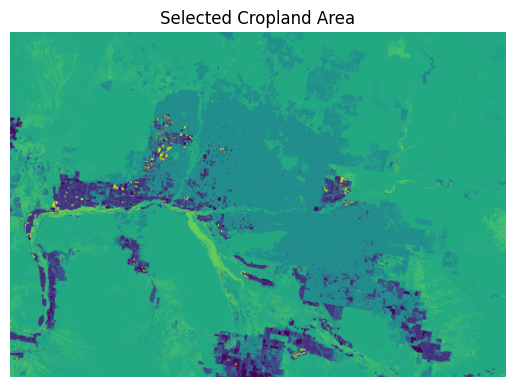

Image saved as /content/selected_area.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Function to export selected region
def export_selected_area():
    roi = Map.user_roi  # Get user-drawn region
    if roi is None:
        print("Please draw a region on the map before exporting!")
        return

    # Clip the image to the selected region
    selected_area = cdl_2022.clip(roi)

    # Export as a NumPy array
    img = geemap.ee_to_numpy(selected_area, region=roi, bands=['cropland'])

    # Plot and save the image
    plt.imshow(img, cmap='viridis')
    plt.axis("off")
    plt.title("Selected Cropland Area")

    # Save as JPEG
    output_file = "/content/selected_area.jpg"
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.show()

    print(f"Image saved as {output_file}")

    # Download the image
    files.download(output_file)

# Run the function to export the selected area
export_selected_area()
